# Importações e Carregamento dos Dados

In [1]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
import requests
import torch
import datasets
import transformers
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

/home/renan/anaconda3/envs/visiondsa/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregamento dos Dados

In [3]:
dados = load_dataset('keremberke/chest-xray-classification', 'full')

In [4]:
print(dados)

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})


In [5]:
exemplo = dados['train'][315]

In [6]:
exemplo

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/60340657865253-config-parquet-and-info-keremberke-chest-xray-cla-9d66ea8b/downloads/extracted/8202f7dd6f1edf5e674abe75990eb233fbbca4408e132a3acd5268bd99708e15/NORMAL/IM-0554-0001_jpeg.rf.33784d58468a84ac8f5b89ea486488c9.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'labels': 0}

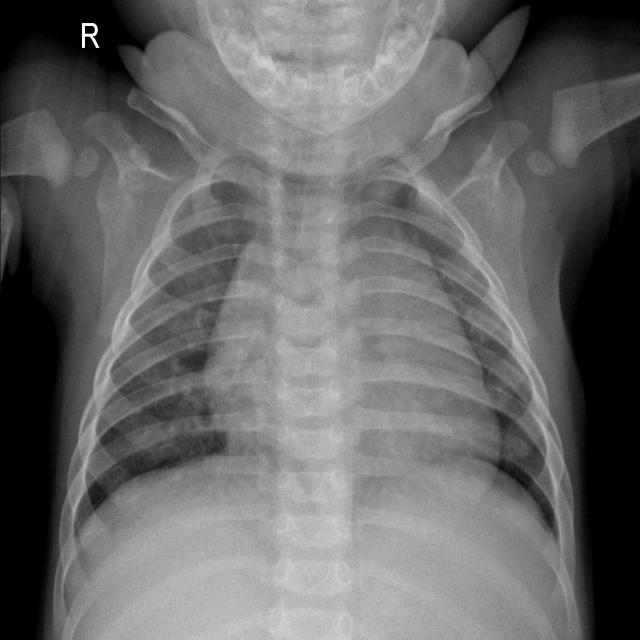

In [7]:
exemplo['image']

## Labels

In [8]:
labels = dados['train'].features['labels']

In [9]:
labels

ClassLabel(names=['NORMAL', 'PNEUMONIA'], id=None)

In [10]:
labels.int2str(exemplo['labels'])

'NORMAL'

# Carregando e Aplicando o ViT Feature Extractor

In [11]:
repo_id = 'google/vit-base-patch16-224-in21k'

In [12]:
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

In [13]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
feature_extractor(exemplo['image'], return_tensors = 'pt')

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

In [15]:
feature_extractor(exemplo['image'], return_tensors = 'pt').keys()

dict_keys(['pixel_values'])

In [16]:
feature_extractor(exemplo['image'], return_tensors = 'pt')['pixel_values'].shape

torch.Size([1, 3, 224, 224])

# Processamento das Imagens

In [17]:
def processa_exemplo(example):
    inputs = feature_extractor(example['image'], return_tensors = 'pt')
    inputs['labels'] = example['labels']
    return inputs

In [18]:
processa_exemplo(dados['train'][0])

{'pixel_values': tensor([[[[-0.8118, -0.7333, -0.7569,  ..., -0.0745, -0.1059, -0.2941],
          [-0.8118, -0.7333, -0.7569,  ..., -0.0824, -0.1294, -0.3020],
          [-0.8118, -0.7333, -0.7569,  ..., -0.0902, -0.1373, -0.3098],
          ...,
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882],
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882],
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882]],

         [[-0.8118, -0.7333, -0.7569,  ..., -0.0745, -0.1059, -0.2941],
          [-0.8118, -0.7333, -0.7569,  ..., -0.0824, -0.1294, -0.3020],
          [-0.8118, -0.7333, -0.7569,  ..., -0.0902, -0.1373, -0.3098],
          ...,
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882],
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882],
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882]],

         [[-0.8118, -0.7333, -0.7569,  ..., -0.0745, -0.1059, -0.2941],
          [-0

In [19]:
def mapeia_lotes(example_batch):
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors = 'pt')
    inputs['labels'] = example_batch['labels']
    return inputs

In [20]:
dados_mapeados = dados.with_transform(mapeia_lotes)

In [21]:
dados_mapeados['train'][0:2]

{'pixel_values': tensor([[[[-0.8118, -0.7333, -0.7569,  ..., -0.0745, -0.1059, -0.2941],
          [-0.8118, -0.7333, -0.7569,  ..., -0.0824, -0.1294, -0.3020],
          [-0.8118, -0.7333, -0.7569,  ..., -0.0902, -0.1373, -0.3098],
          ...,
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882],
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882],
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882]],

         [[-0.8118, -0.7333, -0.7569,  ..., -0.0745, -0.1059, -0.2941],
          [-0.8118, -0.7333, -0.7569,  ..., -0.0824, -0.1294, -0.3020],
          [-0.8118, -0.7333, -0.7569,  ..., -0.0902, -0.1373, -0.3098],
          ...,
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882],
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882],
          [-0.8039, -0.6863, -0.6941,  ..., -0.7490, -0.7490, -0.7882]],

         [[-0.8118, -0.7333, -0.7569,  ..., -0.0745, -0.1059, -0.2941],
          [-0

In [22]:
def collate_fn(batch):
    return {'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.tensor([x['labels'] for x in batch])}

# Construção do Modelo de Treino do ViT

In [23]:
metric = evaluate.load('accuracy')

In [24]:
def calcula_metrica(prediction):
    return metric.compute(predictions= np.argmax(prediction.predictions, axis = 1),
                          references= prediction.label_ids)

In [25]:
labels = dados['train'].features['labels'].names

In [26]:
labels

['NORMAL', 'PNEUMONIA']

In [27]:
model = ViTForImageClassification.from_pretrained(repo_id,
                                                  num_labels = len(labels),
                                                  id2label = {str(i):c for i, c in enumerate(labels)},
                                                  label2id = {c:str(i) for i, c in enumerate(labels)})

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Argumentos de Treino

In [28]:
training_args = TrainingArguments(output_dir='resultados',
                                  evaluation_strategy= 'steps',
                                  num_train_epochs= 4,
                                  learning_rate= 2e-4,
                                  remove_unused_columns= False,
                                  load_best_model_at_end= True)

# Instância de Treino do Modelo

In [29]:
trainer = Trainer(model = model,
                  args = training_args,
                  data_collator= collate_fn,
                  compute_metrics= calcula_metrica,
                  train_dataset= dados_mapeados['train'],
                  eval_dataset= dados_mapeados['validation'],
                  tokenizer= feature_extractor)

# Treinamento e Avaliação do Modelo

In [30]:
%%time
resultado_treino = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.279400,0.122993,0.963948
1000,0.141800,0.109437,0.968240
1500,0.068500,0.099244,0.971674
2000,0.031700,0.104457,0.975107


CPU times: user 10min 36s, sys: 28.2 s, total: 11min 4s
Wall time: 9min 27s


In [31]:
trainer.save_model('modelos')

In [32]:
trainer.log_metrics('train', resultado_treino.metrics)

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1176949000GF
  train_loss               =       0.1279
  train_runtime            =   0:09:27.61
  train_samples_per_second =       28.731
  train_steps_per_second   =        3.594


In [33]:
trainer.save_metrics('train', resultado_treino.metrics)

In [34]:
metrics = trainer.evaluate(dados_mapeados['validation'])
trainer.log_metrics('eval', metrics)
trainer.save_metrics('eval', metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9717
  eval_loss               =     0.0992
  eval_runtime            = 0:00:17.05
  eval_samples_per_second =     68.308
  eval_steps_per_second   =       8.56


# Deploy do Modelo

In [35]:
img = 'teste/Chest_radiograph_in_influensa_and_H_influenzae,_posteroanterior,_annotated.jpg'

In [36]:
image = Image.open(img)

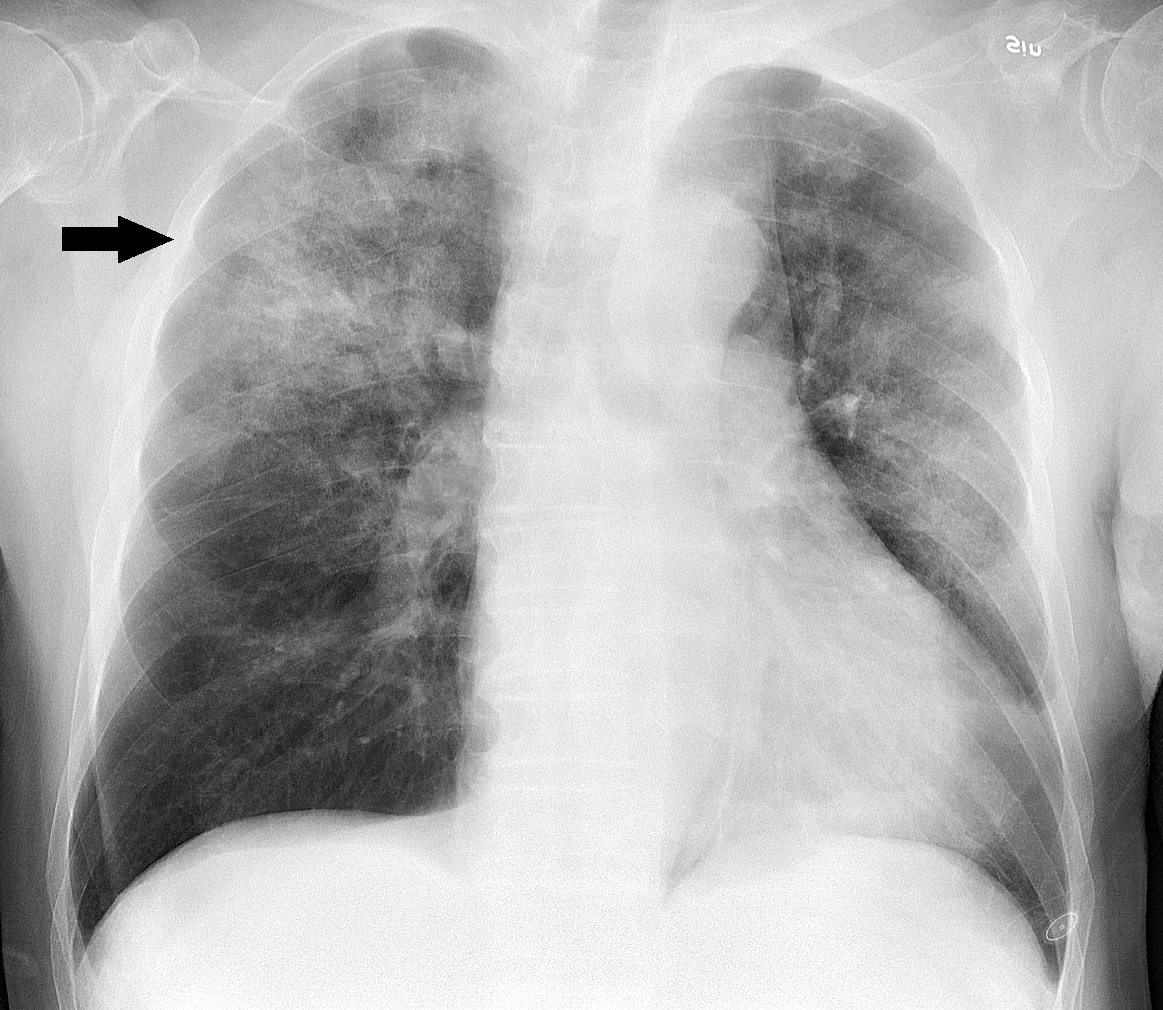

In [45]:
image

In [37]:
inputs = feature_extractor(images = image, return_tensors = 'pt')

In [38]:
inputs = {name: tensor.to(trainer.args.device) for name, tensor in inputs.items()}

In [39]:
inputs

{'pixel_values': tensor([[[[-0.0745, -0.0588, -0.0431,  ..., -0.0588, -0.0667, -0.0745],
           [-0.0118, -0.0039, -0.0039,  ..., -0.0118,  0.0118,  0.1059],
           [ 0.0353,  0.0275,  0.0275,  ...,  0.1373,  0.2000,  0.1765],
           ...,
           [-0.9529, -0.7804, -0.5294,  ..., -0.7804, -0.9686, -0.9373],
           [-0.9373, -0.8196, -0.5373,  ..., -0.7490, -0.9608, -0.9373],
           [-0.9137, -0.8510, -0.5451,  ..., -0.7333, -0.9608, -0.9373]],
 
          [[-0.0745, -0.0588, -0.0431,  ..., -0.0588, -0.0667, -0.0745],
           [-0.0118, -0.0039, -0.0039,  ..., -0.0118,  0.0118,  0.1059],
           [ 0.0353,  0.0275,  0.0275,  ...,  0.1373,  0.2000,  0.1765],
           ...,
           [-0.9529, -0.7804, -0.5294,  ..., -0.7804, -0.9686, -0.9373],
           [-0.9373, -0.8196, -0.5373,  ..., -0.7490, -0.9608, -0.9373],
           [-0.9137, -0.8510, -0.5451,  ..., -0.7333, -0.9608, -0.9373]],
 
          [[-0.0745, -0.0588, -0.0431,  ..., -0.0588, -0.0667, -0.0745

In [40]:
trainer.model.eval()

with torch.no_grad():
    outputs = trainer.model(**inputs)

In [41]:
logits = outputs.logits

In [42]:
class_index = logits.argmax()

In [43]:
class_index

tensor(1, device='cuda:0')

In [44]:
valor = class_index.item()
valor

1

In [46]:
mapeamento_classe = {
  "NORMAL": 0,
  "PNEUMONIA": 1,
}

In [47]:
reverse_mapping = {v: k for k, v in mapeamento_classe.items()}
reverse_mapping

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [49]:
class_name = reverse_mapping.get(valor)

In [50]:
print("A imagem foi classificada como:", class_name)

A imagem foi classificada como: PNEUMONIA
